In [10]:
%matplotlib inline

In [11]:
# Playing around with setting threads. Sometimes more threads makes it worse. Default would be 12 threads on my machine (1 per core).

import torch
torch.set_num_threads(12)
torch.get_num_threads()

12

# SYDE 522 Assignment 4

## Deep Networks and Convolution

### Due: Nov 20, 2025

The purpose of this assignment is to train some deep networks to recognize images.  We will start with MNIST (the standard hand-written numbers dataset) and then go on to the harder CIFAR-10 (recognizing pictures in 10 categories).

All of these datasets are publically available, and for this assignment you should use the Python package `pytorch` to implement and train the neural network.  On most python systems this can be installed with:

```
pip install torch
```

To get access to the datasets we'll use today, you should also install the `torchvision` package, installed with:

```
pip install torchvision
```

This will make it easier to get the data into the `DataSet` class that `pytorch` works with.

For more information on installing, see https://pytorch.org/get-started/locally/

You will need at least python version 3.10. To get an install command tailored to your system, use the selector at the "get started" link.

For this assignment, you will not need to install the GPU version of `pytorch`.  If you want to work with larger deep learning models and make things run faster (for your project, for example), then instructions for doing so are at https://pytorch.org/get-started/locally/

As with all the assignments in this course, this assignment is structured as a Jupyter Notebook and uses Python.  If you do not have Python and Jupyter Notebook installed, the easiest method is to download and install Anaconda https://www.anaconda.com/download.  There is a quick tutorial for running Jupyter Notebook from within Anacoda at https://docs.anaconda.com/free/anaconda/getting-started/hello-world/#python-exercise-jupyter under "Run Python in a Jupyter Notebook"

This assignment sheet is a Jupyter Notebook file https://jupyter.org/ which you can use if you want as a starting point. Implement your assignment directly in the Jupyter notebook and submit your resulting Jupyter Notebook file using Learn.

While you are encouraged to talk about the assignment with your classmates, you must write and submit your own assignment.  Directly copying someone else's assignment and changing a few small things here and there does not count as writing your own assignment.

Make sure to label the axes on all of your graphs. **Don't forget to include confidence intervals!**


## Part 1: MNIST

First, we download the data files.  They are already split into a training set and a test set.

In [12]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import TensorDataset, DataLoader # TensorDataset lets us make datasets from numpy-like arrays


# Define a transform to convert the data to PyTorch tensors and scale the values to be between 0 and 1.
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

batch_size=32 # This is an arbitrary choice, and something you can change to try and improve training performance.


train_mnist_ds = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_mnist_ds = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_mnist_loader = DataLoader(dataset=train_mnist_ds, batch_size=batch_size, shuffle=True)
test_mnist_loader = DataLoader(dataset=test_mnist_ds, batch_size=batch_size, shuffle=False)

Let's show the first 10 training images and their category labels.

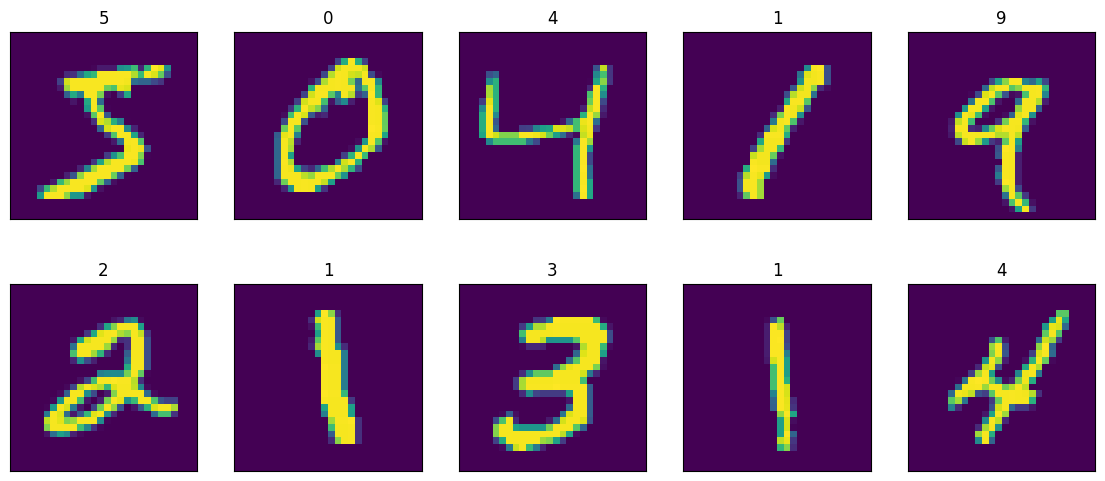

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_mnist_ds.data[i].squeeze())
    plt.xticks([])
    plt.yticks([])
    plt.title('%d' % train_mnist_ds.targets[i])
plt.show()

The `test_mnist_ds.targets` and `train_mnist_ds.targets` values are currently integers (0 to 9).  The output from our network is a vector where one value should be 1 and the others should be 0 (one-hot encoding), so we need to convert to that format.  (Note: there is a special loss function called *sparse categorical crossentropy* that automatically converts for us. In `pytorch` the `CrossEntropyLoss` function provides that for us.  We'll use that later, but for now do this manually, just to keep things clear.)

In [14]:
y_train_target = torch.eye(10)[train_mnist_ds.targets]
y_test_target = torch.eye(10)[test_mnist_ds.targets]
print('original target:', train_mnist_ds.targets[0])
print('  vector target:', y_train_target[0])

original target: tensor(5)
  vector target: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


Now we define the model using Keras https://keras.io/, which is meant for being able to quickly define all the different structures you might want to add to your network. We use `Sequential` to indicate that this is just a big feed-forward network, and we define each layer in turn.  `Linear` is a layer where all the components are connected to all of the previous layer's outputs.

In [15]:
import torch.nn as nn
 
def make_model(num_hidden = 32, num_out=10):
    m = nn.Sequential(
      nn.Flatten(),                       # input is a 28x28 image for MNIST
      nn.Linear(28*28, num_hidden, bias=True),    # 32 neurons in the middle "hidden" layer, have pytorch implement bias (default)
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden, num_out, bias=True),       # 10 outputs (one for each category)
      nn.ReLU(),                          # Add nonlinearity
    )
    return m

We will also need to create dataloaders for training and testing the data. Before we move onto the crossentropy loss, we need to contruct a dataset and dataloader to use our one-hot encoding.

In [16]:
# Note we are applying the transform to the MNIST data here ourselves
train_ds = TensorDataset(transform(train_mnist_ds.data), y_train_target)
test_ds = TensorDataset(transform(test_mnist_ds.data), y_test_target)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

Next, we setup the optimization step by specifying the optimizer and the loss function.

In [17]:
import torch.optim as optim

# define what we want to minimize (the thing that we take the derivative of to get the weight changes)
def criterion(y_true, y_predict):
    return torch.sum((y_true-y_predict)**2, dim=1)

model = make_model()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Before doing any training, let's see how well it performs.

In [18]:
losses = []
is_correct = []

model.eval() # <- Notice, we are switching the model into evaluation mode. No learning!
for images, labels in train_loader:
    outputs = model(images)
    loss = criterion(labels, outputs)
    losses.append(loss)
    is_correct.append(labels.argmax(dim=1) == outputs.argmax(dim=1))

losses = torch.cat(losses)
is_correct = torch.cat(is_correct)
print(f'MSE Loss: {torch.mean(losses).item():.2f}, Accuracy: {torch.mean(is_correct, dtype=torch.float32).item():.2f}')

MSE Loss: 0.96, Accuracy: 0.10


As expected, it's pretty bad, since we haven't done any training yet.  The accuracy is near 10%, which is what we would expect by chance.  But what actual numbers is it outputting?

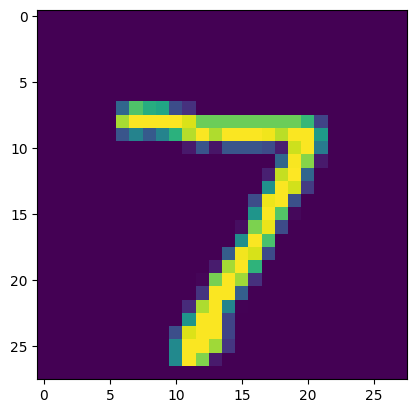

actual output from network: tensor([0.0000, 0.0787, 0.0730, 0.1693, 0.0000, 0.0000, 0.0225, 0.0144, 0.0000,
        0.1801], grad_fn=<SelectBackward0>)
category (the largest output): 9


In [19]:
output = model(test_loader.dataset.tensors[0])
category = output.argmax(dim=1)

plt.imshow(test_loader.dataset.tensors[0][0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0].item())


So it currently thinks the first image in the test dataset is is a 7, when it should actually be a 1 (note: when you run this, you may get a different number, as each network starts out randomly different).  

Now let's try training the model.  We'll just do 5 epochs of training (5 times through all the training data).  While it is training, we also tell it to see how well the model is performing on the testing data (technically this is considered to be validation data, since we're looking at it while we are doing training.  Real testing data would only ever be used at the very end after all training has finished).

First we define a function to perform one epoch of training.

In [20]:
def train_one_epoch(model, criterion, accuracy_fn, optimizer, training_loader, epoch_index, batch_print=1000):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    
    correct = 0 # Count number of correct labels, assuming a classification task.
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        correct += accuracy_fn(outputs, labels)

        # Gather data and report
        running_loss += loss.item()
        if i % batch_print == batch_print-1:
            last_loss = running_loss / 1000 # loss per batch
            print(f'  batch {i + 1} loss: {last_loss:.3e}')
            running_loss = 0.

    return last_loss, correct / len(training_loader.dataset)


Next we define the training loop

In [21]:
from datetime import datetime

def train_model(model, criterion, accuracy_fn, optimizer, training_loader, validation_loader=None, 
                num_epochs=5, batch_print=1000, eval_funcs=None, model_logging=False):

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    best_vloss = 1_000_000.
    

    training_loss = []
    validation_loss = []
    
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        print(f'EPOCH {epoch + 1}:')

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True) # <- Note, we are putting the model back in training mode.
        avg_loss, accuracy = train_one_epoch(model, criterion, accuracy_fn, optimizer, training_loader, epoch, batch_print=batch_print)


        training_loss.append(avg_loss)
        training_accuracy.append(accuracy)
        running_vloss = 0.0
        

        if validation_loader is None:
            # No validation data, skip evaluation
            continue
            
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        
        # Disable gradient computation and reduce memory consumption.
        val_correct = 0
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss

                val_correct += accuracy_fn(voutputs, vlabels)
                #(voutputs.argmax(dim=1)==vlabels.argmax(dim=1)).float().sum()

        avg_vloss = running_vloss / (i + 1)
        val_acc = val_correct / len(validation_loader.dataset)
        
        validation_loss.append(avg_vloss)
        validation_accuracy.append(val_acc)
        print(f'LOSS train {avg_loss:.3e} valid {avg_vloss:.3e}, train acc {accuracy:.2f}, val acc {val_acc:.2f}')

        # Track best performance, and save the model's state
        if model_logging and avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)
        
    return {
        'loss':training_loss,
        'val_loss':validation_loss,
        'accuracy':training_accuracy,
        'val_accuracy':validation_accuracy,
           }


And, finally, we need to define a loss function in a way that is compatible with the Pytorch framework. This is something that will permit the automatic gradient to propagate back through the loss function.

In [22]:
class MeanSquareError(nn.Module):
    def __init__(self):
        super(MeanSquareError, self).__init__()
    def forward(self, y_true, y_pred):
        return torch.mean((y_true - y_pred)**2)
    
def one_hot_accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=1) == y_true.argmax(dim=1)).float().sum()
    

**Note:** Below we have you recreate the model **and** the optimizer. If you model is not learning, make sure that the optimizer you are using is pointing at the parameters of the model you are trying to train. In other words, if you make a new model, you need to make a new optimizer too.

In [ ]:
model = make_model()
model.train()

criterion = MeanSquareError() # Note, Pytorch provides nn.MSELoss(), but we want to see how to make our own loss.
optimizer = optim.SGD(model.parameters(), lr=0.1)
history = train_model(
    model, 
    criterion, 
    one_hot_accuracy, 
    optimizer, 
    train_loader, 
    test_loader, 
    num_epochs=5, 
    batch_print=100,
)

We can plot the categorization accuracy over time and the error over time for both the training set and the test set.

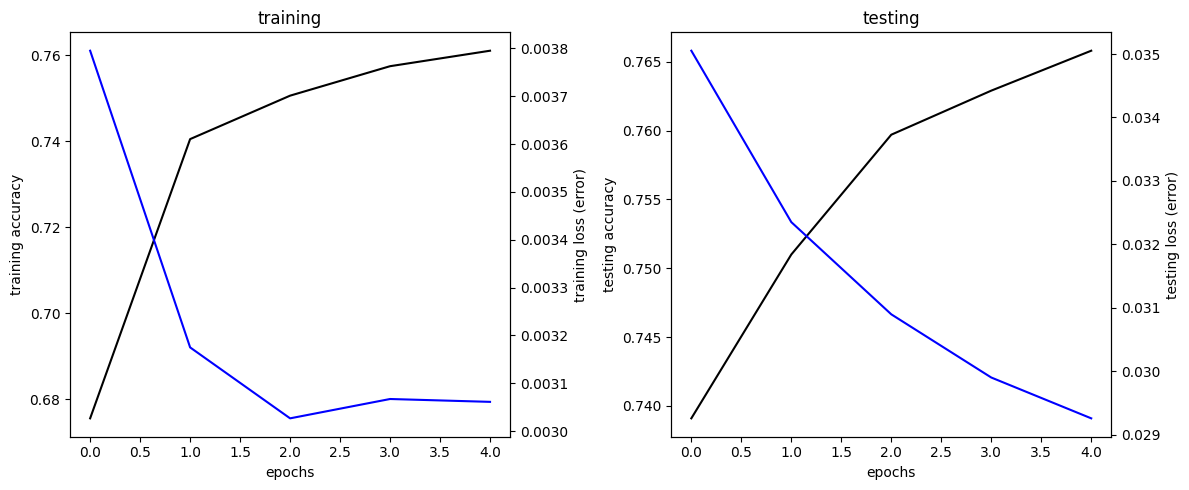

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

Now let's see how well it performs on the test set.

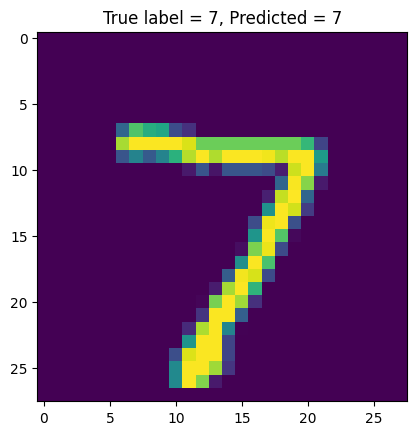

actual output from network: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9122, 0.0000,
        0.0000], grad_fn=<SelectBackward0>)
category (the largest output): tensor(7)


In [25]:
output = model(test_loader.dataset.tensors[0])
category = output.argmax(dim=1)

plt.imshow(test_loader.dataset.tensors[0][0])
plt.title(f'True label = {test_loader.dataset.tensors[1][0].argmax()}, Predicted = {category[0]}' )
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])

Well it learned the first item well, but it's only getting around 85% on the test set (which is also about what it's getting on the training set).  To get a better sense of what it's doing, let's generate the *confusion* matrix.  This indicates what category it puts things in, as compared to what category they should be in.

In [26]:
confusion=torch.zeros((10,10), dtype=int)
confusion=torch.index_put(confusion, (category, test_mnist_ds.targets), torch.LongTensor([1]), accumulate=True)
print(confusion)

tensor([[ 969,    2,   15,  481,    3,   19,  540,    3,   12,   14],
        [   0, 1119,    0,   31,    2,    4,   12,   10,    2,    7],
        [   1,    5,  987,  109,    8,    4,  102,   22,    8,    1],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    1,   12,   32,  933,    3,   96,    8,   10,   29],
        [   3,    2,    1,  173,    1,  841,  144,    2,   18,    7],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   3,    1,    7,   39,    2,    3,    1,  966,    6,    9],
        [   3,    5,    9,  118,    4,   14,   61,    2,  913,   12],
        [   0,    0,    1,   27,   29,    4,    2,   15,    5,  930]])


The ideal confusion matrix will have ~1000 along the diagonal and 0 everywhere else.  According to this confusion matrix (yours will be different), 9's got mis-calssified as 4's a lot (and vice-versa).

**1. [1 mark]:** Run the MNIST model as defined here 10 times.  Note that you have to re-create the `model` each time: if you just run `train_model` over again, then it will just train the same model, continuing from where it left off.  Each of the 10 models should be trained for 5 epochs.  Make a single plot with training accuracy vs epoch for all 10 runs. Use the code to compute bootstrap confidence intervals from assignment 3. You should see that each time you train the model, it behaves differently.  Why does this happen? 

In [ ]:
import scipy as sp
import numpy as np

history_array = []
for i in range(10):
    model = make_model()
    model.train()

    criterion = MeanSquareError() # Note, Pytorch provides nn.MSELoss(), but we want to see how to make our own loss.
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    history = train_model(
        model, 
        criterion, 
        one_hot_accuracy, 
        optimizer, 
        train_loader, 
        test_loader, 
        num_epochs=5, 
        batch_print=100,
    )

    history_array.append(history)   
    


Epoch 1: 95% CI for mean accuracy: (0.6295, 0.7299)
Epoch 2: 95% CI for mean accuracy: (0.7247, 0.8103)
Epoch 3: 95% CI for mean accuracy: (0.7475, 0.8365)
Epoch 4: 95% CI for mean accuracy: (0.7662, 0.8589)
Epoch 5: 95% CI for mean accuracy: (0.7718, 0.8663)


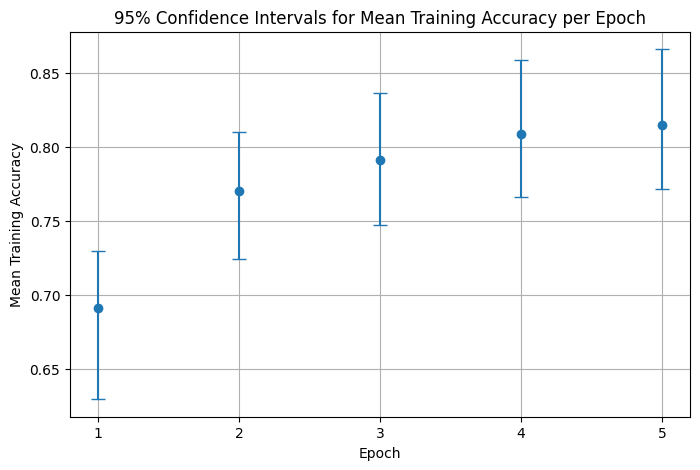

In [25]:
# Extract epoch values efficiently using numpy
epoch_array = []
training_accuracies = np.array([history['accuracy'] for history in history_array])
for i in range(5):
    epoch_array.append(training_accuracies[:, i])

# Initialize confidence interval arrays:
ci_highs = []
ci_lows = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    ci_low, ci_high = sp.stats.bootstrap([epoch_values], np.mean).confidence_interval
    ci_lows.append(ci_low)
    ci_highs.append(ci_high)

# PRINT THE CONFIDENCE INTERVALS
for epoch_idx, (ci_low, ci_high) in enumerate(zip(ci_lows, ci_highs), start=0):
    print(f'Epoch {epoch_idx + 1}: 95% CI for mean accuracy: ({ci_low:.4f}, {ci_high:.4f})')

# PLOT THE CONFIDENCE INTERVALS PER EPOCH
plt.figure(figsize=(8,5))
epochs = np.arange(1, 6)
mean_accuracies = [np.mean(epoch_values) for epoch_values in epoch_array]
ci_lows = np.array(ci_lows)
ci_highs = np.array(ci_highs)
error_bars = [mean_accuracies - ci_lows, ci_highs - mean_accuracies]
plt.errorbar(epochs, mean_accuracies, yerr=error_bars, fmt='o', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Accuracy')
plt.title('95% Confidence Intervals for Mean Training Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()

The models behave differently because when initialized, the neural network weights are randomly chosen, which sends each model on a different path when trained. This will create variance.

**2. [1 mark]:** Do the same thing as question 1, but train for 20 epochs.  Plot the training error vs epochs, with confidence intervals, for 10 different runs on one plot.  On a separate plot show the testing **error** vs epochs for the 10 different runs.  How does the testing error compare to the training error?  Do the models all eventually learn to solve the problem well?  What happens to them?

In [ ]:
import scipy as sp
import numpy as np

history_array = []
for i in range(10):
    model = make_model()
    model.train()

    criterion = MeanSquareError() # Note, Pytorch provides nn.MSELoss(), but we want to see how to make our own loss.
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    history = train_model(
        model, 
        criterion, 
        one_hot_accuracy, 
        optimizer, 
        train_loader, 
        test_loader, 
        num_epochs=20, 
        batch_print=100,
    )

    history_array.append(history)

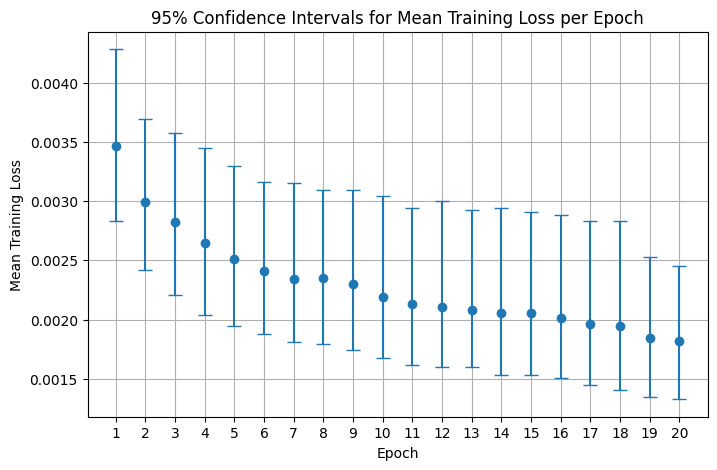

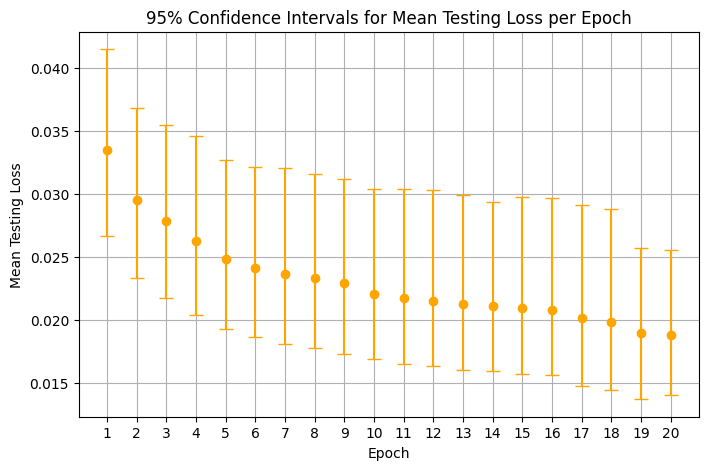

In [46]:
# Extract epoch values
epoch_array = []
training_losses = np.array([history['loss'] for history in history_array])
testing_losses = np.array([history['val_loss'] for history in history_array])
for i in range(20):
    epoch_array.append((training_losses[:, i], testing_losses[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
mean_losses_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_losses_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_losses_training - ci_lows_training, ci_highs_training - mean_losses_training]
plt.errorbar(epochs, mean_losses_training, yerr=error_bars_training, fmt='o', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('95% Confidence Intervals for Mean Training Loss per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_losses_testing - ci_lows_testing, ci_highs_testing - mean_losses_testing]
plt.errorbar(epochs, mean_losses_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Loss')
plt.title('95% Confidence Intervals for Mean Testing Loss per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()

The testing error seems to be almost 10 times higher than the training error! I cannot properly evaluate whether or not the model completed the task well from loss alone. I need to see the accuracy since we are evaluating whether or not it classified properly. I am going to print the accuracy for this reason. From the loss I can tell that it definitely learned and leveled off, meaning that it likely reached convergence.

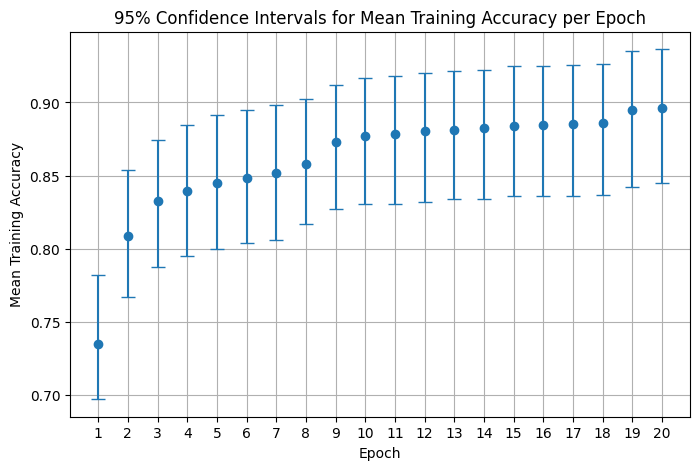

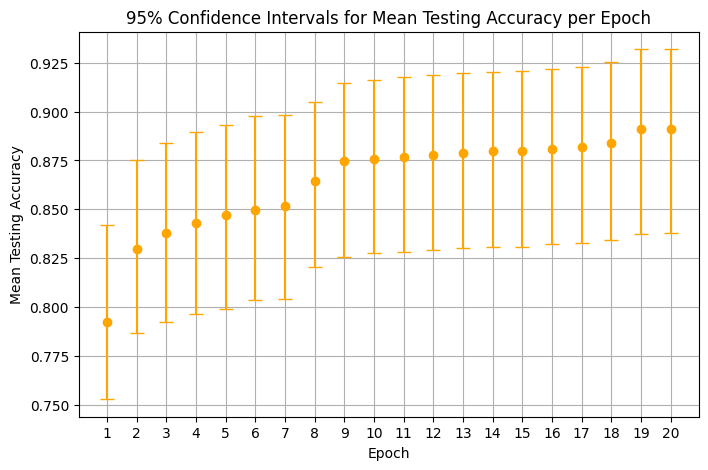

In [32]:
# Extract epoch values
epoch_array = []
training_accuracies = np.array([history['accuracy'] for history in history_array])
testing_accuracies = np.array([history['val_accuracy'] for history in history_array])
for i in range(20):
    epoch_array.append((training_accuracies[:, i], testing_accuracies[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
mean_accuracies_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_accuracies_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_accuracies_training - ci_lows_training, ci_highs_training - mean_accuracies_training]
plt.errorbar(epochs, mean_accuracies_training, yerr=error_bars_training, fmt='o', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Accuracy')
plt.title('95% Confidence Intervals for Mean Training Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_accuracies_testing - ci_lows_testing, ci_highs_testing - mean_accuracies_testing]
plt.errorbar(epochs, mean_accuracies_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Accuracy')
plt.title('95% Confidence Intervals for Mean Testing Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()

How does the testing accuracy compare to the training accuracy? Do the models all eventually learn to solve the problem well? What happens to them?

All models learn to solve the problem well, with average accuracies in the 90% range, and a minimum expected accuracy of about 85%. The accuracy rapidly improves between epochs 1-4, slowly leveling off until it reaches an equilibrium around epoch 14. Strangely, the testing accuracy is very close to the training accuracy, and is even slightly higher at times. This is very interesting since the loss is 10x higher.

**3. [1 mark]:** Repeat question 2 (generating the same 2 plots), but with a learning rate of 0.01.  How does this affect the learning performance?

In [ ]:
import scipy as sp
import numpy as np

history_array = []
for i in range(10):
    model = make_model()
    model.train()

    criterion = MeanSquareError() # Note, Pytorch provides nn.MSELoss(), but we want to see how to make our own loss.
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    history = train_model(
        model, 
        criterion, 
        one_hot_accuracy, 
        optimizer, 
        train_loader, 
        test_loader, 
        num_epochs=20, 
        batch_print=100,
    )

    history_array.append(history)

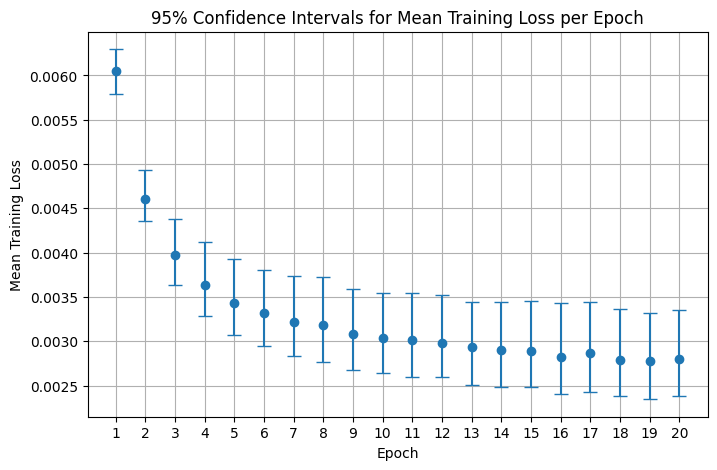

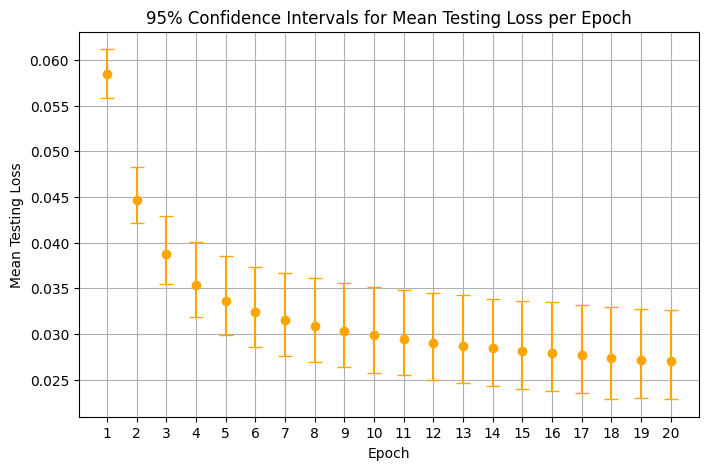

In [48]:
# Extract epoch values
epoch_array = []
training_losses = np.array([history['loss'] for history in history_array])
testing_losses = np.array([history['val_loss'] for history in history_array])
for i in range(20):
    epoch_array.append((training_losses[:, i], testing_losses[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
mean_losses_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_losses_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_losses_training - ci_lows_training, ci_highs_training - mean_losses_training]
plt.errorbar(epochs, mean_losses_training, yerr=error_bars_training, fmt='o', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('95% Confidence Intervals for Mean Training Loss per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_losses_testing - ci_lows_testing, ci_highs_testing - mean_losses_testing]
plt.errorbar(epochs, mean_losses_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Loss')
plt.title('95% Confidence Intervals for Mean Testing Loss per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()

This time around the initial performance was far worse (loss far higher epoch 1), and the loss did not drop as substaintially as in Q2. It should also be noted that the loss does not seem like it has leveled off yet and is higher than the previous question. With a slower learning rate this makes sense because it should take longer to minimize loss. Overall, I would say that the learning perfomrance has degraded in that it has gotten slower, and seems that it would take a very long time to match the loss of the above question.

**4. [1 mark]:** Instead of standard Stochastic Gradient Descent, most modern machine learning researchers use a variation of it called [Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html) that automatically adjusts the learning rate and does a better local estimate of the gradient.  We can switch to this by changing `optimizer=optim.SGD(model.parameters(), lr=0.1)` to `optimizer=optim.Adam(model.parameters())`.  Repeat question 2 (generating the same 2 plots) using the Adam optimizer.  How does this affect the learning performance?

In [ ]:
import scipy as sp
import numpy as np

history_array = []
for i in range(10):
    model = make_model()
    model.train()

    criterion = MeanSquareError() # Note, Pytorch provides nn.MSELoss(), but we want to see how to make our own loss.
    optimizer=optim.Adam(model.parameters())
    history = train_model(
        model, 
        criterion, 
        one_hot_accuracy, 
        optimizer, 
        train_loader, 
        test_loader, 
        num_epochs=20, 
        batch_print=100,
    )

    history_array.append(history)

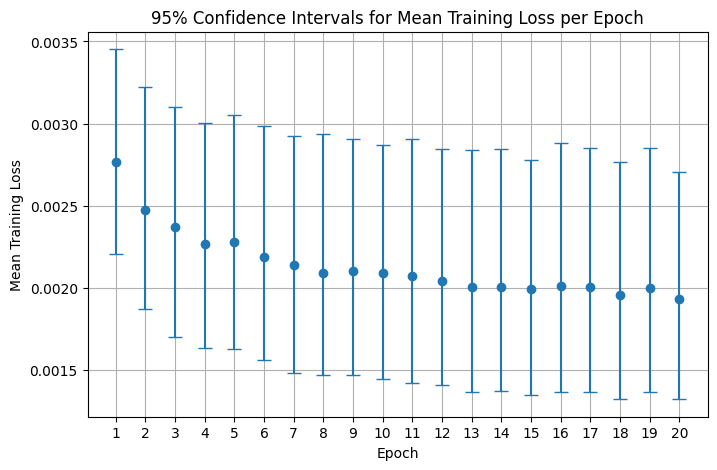

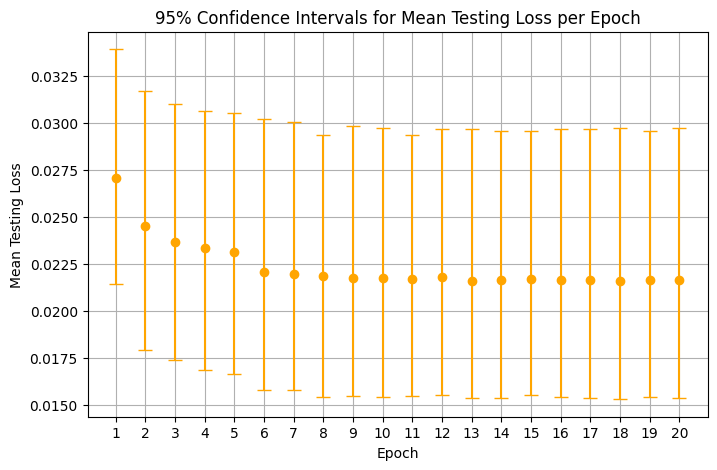

In [52]:
# Extract epoch values
epoch_array = []
training_losses = np.array([history['loss'] for history in history_array])
testing_losses = np.array([history['val_loss'] for history in history_array])
for i in range(20):
    epoch_array.append((training_losses[:, i], testing_losses[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
mean_losses_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_losses_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_losses_training - ci_lows_training, ci_highs_training - mean_losses_training]
plt.errorbar(epochs, mean_losses_training, yerr=error_bars_training, fmt='o', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('95% Confidence Intervals for Mean Training Loss per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_losses_testing - ci_lows_testing, ci_highs_testing - mean_losses_testing]
plt.errorbar(epochs, mean_losses_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Loss')
plt.title('95% Confidence Intervals for Mean Testing Loss per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()

The training was very slowly improving, and ended up worse than the initial hard coded learning rate in Q2. The error seemed to level off quickly which is different from Q2, implying it likely converged faster. It performed really well epoch 1, but after that learning performance was a lot slower. It ended off at a higher loss. There was still the same ~10x difference in loss from testing to training data.

**5. [1 mark]**: To improve performance, we can also change the output layer of neurons to be a `softmax` layer.  This means that they will automatically be normalized with the softmax function (so the output of neuron $i$ will be ${e^{a_i} / \sum_j e^{a_j}}$).  This should push the output value closer to the sort of output we want (all zeros with a single 1).  Furthermore, instead of doing the error as $(t-y)^2$, we can instead choose an error function that is only concerned about categorization.  After all, the only thing we care about when categorizing is which of the outputs is largest, not whether they are exactly 0 or 1.  Conveniently, tensorflow (and many other deep learning libraries) also contains a version of this function that works directly on category labels, so we don't have to do the `y_train_target = torch.eye(10)[y_train]` trick in the code above.  The resulting network looks like this:

In [6]:
def make_softmax_model(num_hidden = 32, num_out=10):
    m = nn.Sequential(
      nn.Flatten(),                       # input is a 28x28 image for MNIST
      nn.Linear(28*28, num_hidden, bias=True),    # 32 neurons in the middle "hidden" layer, have pytorch implement bias (default)
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden, num_out, bias=True),       # 10 outputs (one for each category)
      nn.Softmax(),                          # Add nonlinearity
    )
    return m


def cross_entropy_accuracy(y_pred, y_true):
    '''
    We need to change the accuracy function because the output is a vector encoding a distribution 
    over the categories, but the true label is just the class number.
    '''
    return (y_pred.argmax(dim=1) == y_true).float().sum()

In [ ]:
softmax_model = make_softmax_model()

optimizer = optim.Adam(softmax_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
criterion = nn.CrossEntropyLoss()

history = train_model(
    softmax_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_mnist_loader, 
    test_mnist_loader, 
    num_epochs=20, 
    batch_print=100,
)

In [ ]:
import scipy as sp
import numpy as np

history_array = []
for i in range(10):
    softmax_model = make_softmax_model()
    optimizer = optim.Adam(softmax_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
    criterion = nn.CrossEntropyLoss()

    history = train_model(
        softmax_model, 
        criterion, 
        cross_entropy_accuracy, 
        optimizer, 
        train_mnist_loader, 
        test_mnist_loader, 
        num_epochs=20, 
        batch_print=100,
    )

    history_array.append(history)

In [ ]:
# LOAD HISTORY ARRAY from q5 pickle
import pickle
with open('q5_history_array.pkl', 'rb') as f:
    history_array = pickle.load(f)

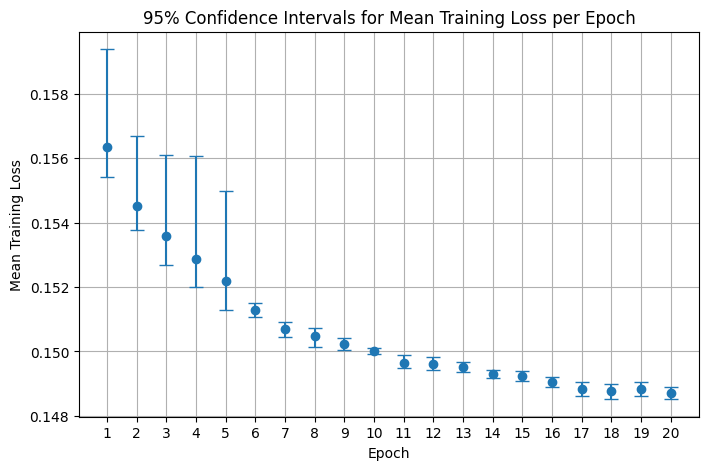

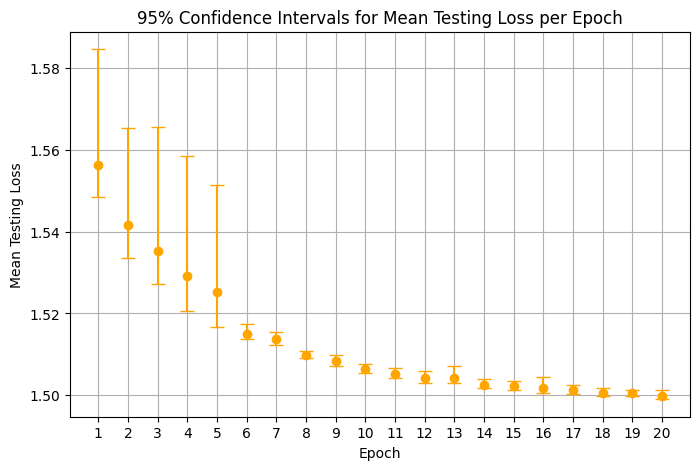

In [24]:
import numpy as np
import scipy as sp

# Extract epoch values
epoch_array = []
training_losses = np.array([history['loss'] for history in history_array])
testing_losses = np.array([history['val_loss'] for history in history_array])
for i in range(20):
    epoch_array.append((training_losses[:, i], testing_losses[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
mean_losses_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_losses_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_losses_training - ci_lows_training, ci_highs_training - mean_losses_training]
plt.errorbar(epochs, mean_losses_training, yerr=error_bars_training, fmt='o', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Loss')
plt.title('95% Confidence Intervals for Mean Training Loss per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_losses_testing - ci_lows_testing, ci_highs_testing - mean_losses_testing]
plt.errorbar(epochs, mean_losses_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Loss')
plt.title('95% Confidence Intervals for Mean Testing Loss per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()

Generate the same 2 plots as in question 2.  How do these changes affect the learning performance?


It looks like the learning may be a bit slower with this new model, and the new changes. The loss function is different so I will calculate accuracy to compare to Q2. I notice that the initial loss was not too far off the final loss. This tells me that the model got quite accurate initially. I am going to calculate accuracy to better evaluate learning performance.

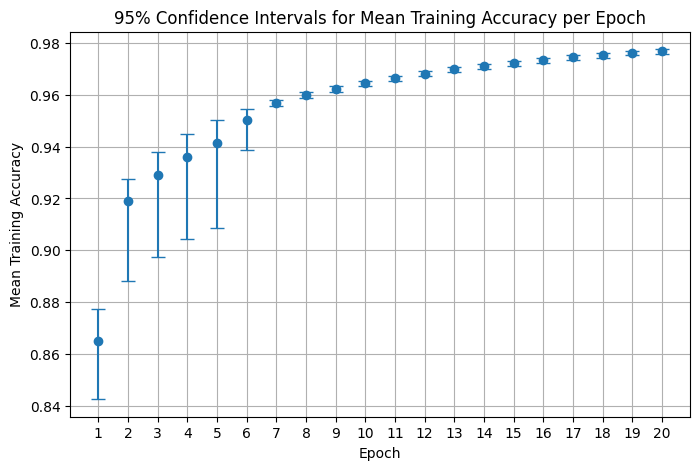

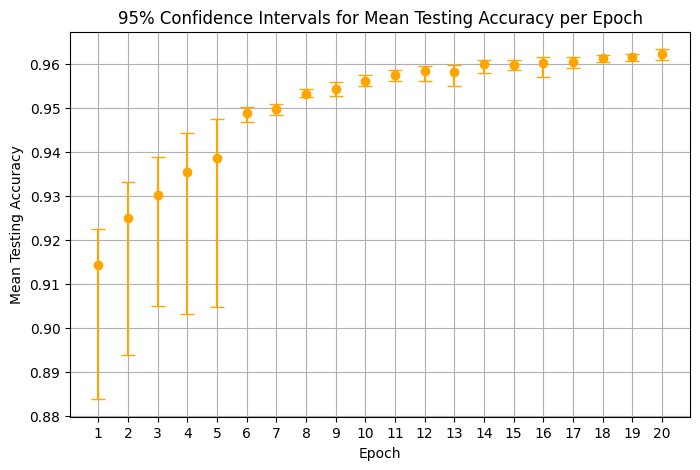

In [2]:
#IMPORT Q5 PICKLE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

with open('q5_history_array.pkl', 'rb') as f:
    history_array = pickle.load(f)

# Extract epoch values
epoch_array = []
training_accuracies = np.array([history['accuracy'] for history in history_array])
testing_accuracies = np.array([history['val_accuracy'] for history in history_array])
for i in range(20):
    epoch_array.append((training_accuracies[:, i], testing_accuracies[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
mean_accuracies_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_accuracies_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_accuracies_training - ci_lows_training, ci_highs_training - mean_accuracies_training]
plt.errorbar(epochs, mean_accuracies_training, yerr=error_bars_training, fmt='o', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Accuracy')
plt.title('95% Confidence Intervals for Mean Training Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 21)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_accuracies_testing - ci_lows_testing, ci_highs_testing - mean_accuracies_testing]
plt.errorbar(epochs, mean_accuracies_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Accuracy')
plt.title('95% Confidence Intervals for Mean Testing Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()





The epoch 1 accuracy in Q5 is better than the epoch 20 accuracy in Q2. The model also seems it is still learning at epoch 20. As well it should be noted that the confidence intervals are extremely tiny. Even the intial ones are small compared to question 2 when you acccount for the far smaller scale on the y axis. This means that this approach is far more reliable, with less run to run variance.

It seems that the learning performance here is a substantial increase, and yields far better results quicker.

**6. [2 marks]:** Using the final version of the model (from question 5), explore the performance of the model as you change the number of neurons in the hidden layer.  Try 2, 4, 8, 16, 32, 64, 128, and 256.  For each value, train 10 models for 10 epochs each.  We do not need the testing accuracy over the epochs, so you can switch back to setting `num_epochs=10` rather than using the `for` loop.  Plot the average training accuracy (with confidence intervals) vs different numbers of neurons.  On a separate plot, plot the average testing accuracy (with confidence intervals) vs different numbers of neurons.  What trend do you observe?

In [ ]:
import scipy as sp
import numpy as np

history_array = []
hidden_layers = [2,4,8,16,32,64,128,256]
for layer_size in hidden_layers:
    layer_history = []
    for _ in range(10):
        softmax_model = make_softmax_model(num_hidden=layer_size)
        optimizer = optim.Adam(softmax_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
        criterion = nn.CrossEntropyLoss()

        history = train_model(
            softmax_model, 
            criterion, 
            cross_entropy_accuracy, 
            optimizer, 
            train_mnist_loader, 
            test_mnist_loader, 
            num_epochs=10, 
            batch_print=100,
        )
        layer_history.append(history)
        
    history_array.append(layer_history)

Loading the q6 history data:

In [34]:
# IMPORT ARRAY
import pickle
with open('Q6_history_array.pkl', 'rb') as f:
    history_array = pickle.load(f)
    hidden_layers = [2,4,8,16,32,64,128,256]


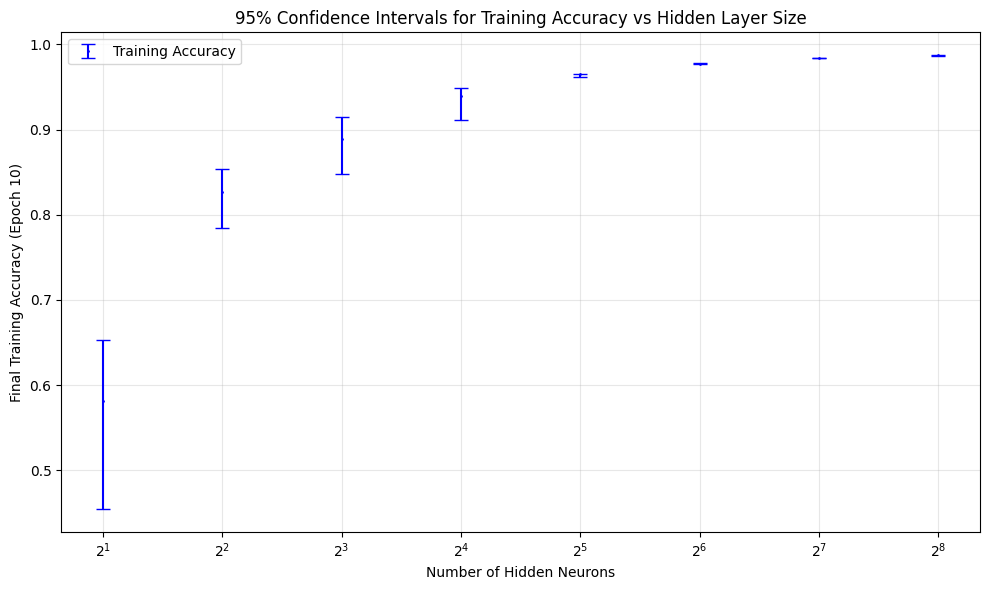

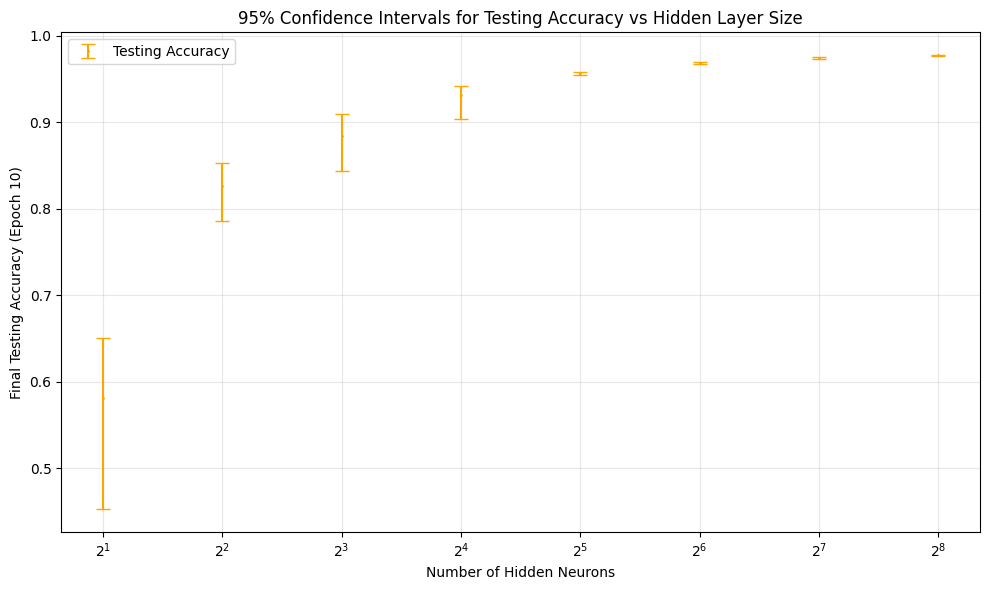

In [35]:
# Extract final epoch accuracies (epoch 10, index 9) for each layer size
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

final_training_accuracies = []
final_testing_accuracies = []
mean_training_accuracies = []
mean_testing_accuracies = []
ci_lows_training = []
ci_highs_training = []
ci_lows_testing = []
ci_highs_testing = []

for layer_idx, layer_size in enumerate(hidden_layers):
    # Get final accuracies from all 10 runs for this layer size
    layer_train_accs = []
    layer_test_accs = []
    
    for run_history in history_array[layer_idx]:
        layer_train_accs.append(run_history['accuracy'][9])  # Final epoch training accuracy
        layer_test_accs.append(run_history['val_accuracy'][9])  # Final epoch testing accuracy
    
    final_training_accuracies.append(layer_train_accs)
    final_testing_accuracies.append(layer_test_accs)
    
    # Compute confidence intervals for this layer size
    training_values = np.array(layer_train_accs)
    testing_values = np.array(layer_test_accs)
    
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    
    mean_training_accuracies.append(np.mean(training_values))
    mean_testing_accuracies.append(np.mean(testing_values))
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)
    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# Convert to numpy arrays for plotting
mean_training_accuracies = np.array(mean_training_accuracies)
mean_testing_accuracies = np.array(mean_testing_accuracies)
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)

# PLOT TRAINING ACCURACY VS HIDDEN NEURONS
plt.figure(figsize=(10, 6))
error_bars_training = [mean_training_accuracies - ci_lows_training, 
                      ci_highs_training - mean_training_accuracies]
plt.errorbar(hidden_layers, mean_training_accuracies, yerr=error_bars_training, 
             fmt='o', capsize=5, markersize=1, color='blue', label='Training Accuracy')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Final Training Accuracy (Epoch 10)')
plt.title('95% Confidence Intervals for Training Accuracy vs Hidden Layer Size')
plt.xticks(hidden_layers, hidden_layers)
plt.xscale('log', base=2)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# PLOT TESTING ACCURACY VS HIDDEN NEURONS  
plt.figure(figsize=(10, 6))
error_bars_testing = [mean_testing_accuracies - ci_lows_testing, 
                     ci_highs_testing - mean_testing_accuracies]
plt.errorbar(hidden_layers, mean_testing_accuracies, yerr=error_bars_testing, 
             fmt='o', capsize=5, markersize=1, color='orange', label='Testing Accuracy')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Final Testing Accuracy (Epoch 10)')
plt.title('95% Confidence Intervals for Testing Accuracy vs Hidden Layer Size')
plt.xticks(hidden_layers, hidden_layers)
plt.xscale('log', base=2)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

What trend do you observe?

Performance improves a lot from 2 layers all the way up to 32 hidden layers (the default in this model). Past 32 layers however, we see very minimal improvement. There is a slight change to 64 layers but after that we see virtually no improvement whatsoever. It should also be noted that variance is extremely high until 16 layers, and does not get consistent in my opinion till 32. The trend is that there is low accuracy and high variance until 32 layers, where it seems to converge and level off. 

In [48]:
# LOAD THE Q6 ARRAY:
import pickle
with open('Q6_history_array.pkl', 'rb') as f:
    history_array = pickle.load(f)
    hidden_layers = [2,4,8,16,32,64,128,256]

# PRINT THE CONFIDENCE INTERVALS FOR TESTING ACCURACY FOR THE LAST THREE LAYERS:
for layer_idx in [-3, -2, -1]:
    layer_size = hidden_layers[layer_idx]
    layer_test_accs = []
    
    for run_history in history_array[layer_idx]:
        layer_test_accs.append(run_history['val_accuracy'][9])  # Final epoch testing accuracy
    
    testing_values = np.array(layer_test_accs)
    
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    
    print(f'Layer size {layer_size}: 95% CI for mean testing accuracy: ({ci_low_test:.4f}, {ci_high_test:.4f})')

Layer size 64: 95% CI for mean testing accuracy: (0.9668, 0.9690)
Layer size 128: 95% CI for mean testing accuracy: (0.9731, 0.9747)
Layer size 256: 95% CI for mean testing accuracy: (0.9766, 0.9775)


Looking above, what I was talking about becomes more apparent. There are very miniscule improvements past 32 layers - the CIs are very similar to each other.

**7. [2 marks]:** The overall goal is to make the network perform as well as possible on the testing data.  What would you do if your job was to make the best possible network for this task?  Try some things and report your results.  For example, try adding a second hidden layer to the model.  Try making it different sizes. What about having no hidden layer?  Or more than 2?  Report the results of your exploration.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

First we will try to add a second hidden layer with 64 neurons. Since this has been very computationally expensive, from previous tests it seems that 15 epochs does not yield significantly different results than 20 epochs, but does provide improvements from 10 epochs. As well, as the number of hidden layers increase, we can see that the confidence interval is so small that there is not much point running 10 runs (with each run taking 2 minutes on my computer). For now on with large amounts of hidden layers (>=32), I will run one time only.

I admit this is not the best approach; however, computation time is just too long to run everything for 10 runs. I will rely on previous confidence intervals to reject the null hypothesis that previous methods are better.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Let us add a second hidden layer. Both hidden layers will be of size 64 neurons.

In [40]:
# ADD A SECOND HIDDEN LAYER TO THE MODEL
def make_two_hidden_layer_model(num_hidden1 = 64, num_hidden2=64, num_out=10):
    m = nn.Sequential(
      nn.Flatten(),                       # input is a 28x28 image for MNIST
      nn.Linear(28*28, num_hidden1, bias=True),    # first hidden layer
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden1, num_hidden2, bias=True), # second hidden layer
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden2, num_out, bias=True),       # output layer
      nn.Softmax(),                          # Add nonlinearity
    )
    return m

In [ ]:
# IMPLEMENT THE 2 HIDDEN LAYER MODEL AND TRAIN IT
two_hidden_model = make_two_hidden_layer_model()
optimizer = optim.Adam(two_hidden_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
criterion = nn.CrossEntropyLoss()
history = train_model(
    two_hidden_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_mnist_loader, 
    test_mnist_loader, 
    num_epochs=15, 
    batch_print=100,
)


In [47]:

# PRINT THE ACCURACY
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy: {final_test_acc:.4f}')

Final Testing Accuracy: 0.9735


Based on this accuracy, we are within the confidence interval of 128 layers, 10 epochs. This makes an improvement over 64, but is not very significant. Lets change the layers to use 256 neurons each.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
# ADD A SECOND HIDDEN LAYER TO THE MODEL
def make_two_hidden_layer_model(num_hidden1 = 256, num_hidden2=256, num_out=10):
    m = nn.Sequential(
      nn.Flatten(),                       # input is a 28x28 image for MNIST
      nn.Linear(28*28, num_hidden1, bias=True),    # first hidden layer
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden1, num_hidden2, bias=True), # second hidden layer
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden2, num_out, bias=True),       # output layer
      nn.Softmax(),                          # Add nonlinearity
    )
    return m

In [ ]:
# IMPLEMENT THE 2 HIDDEN LAYER MODEL AND TRAIN IT
two_hidden_model = make_two_hidden_layer_model()
optimizer = optim.Adam(two_hidden_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
criterion = nn.CrossEntropyLoss()
history = train_model(
    two_hidden_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_mnist_loader, 
    test_mnist_loader, 
    num_epochs=15, 
    batch_print=100,
)



In [51]:
# PRINT THE ACCURACY
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy: {final_test_acc:.4f}')

Final Testing Accuracy: 0.9728


Accuracy got worse. We are now better than 64 layers but worse than 128. I am going to try no hidden layers at all

In [52]:
def make_no_hidden_layer_model(num_out=10):
    m = nn.Sequential(
        nn.Flatten(),                       # input is a 28x28 image for MNIST
        nn.Linear(28*28, num_out, bias=True),    # Direct connection: input to output
        nn.Softmax(),                       # Only softmax at the end
    )
    return m

In [ ]:
# IMPLEMENT THE 2 HIDDEN LAYER MODEL AND TRAIN IT
two_hidden_model = make_no_hidden_layer_model()
optimizer = optim.Adam(two_hidden_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
criterion = nn.CrossEntropyLoss()
history = train_model(
    two_hidden_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_mnist_loader, 
    test_mnist_loader, 
    num_epochs=15, 
    batch_print=100,
)



In [54]:
# PRINT THE ACCURACY
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy: {final_test_acc:.4f}')

Final Testing Accuracy: 0.9320


Much worse accuracy. Do not use it. 

The accuracy from part 6 was already so high that adding more layers and changing the sizes are not changing much. I think we might be getting to the limit of the model we are using. Maybe we can try changing the model. Computation time is long so maybe there is a model that performs as well, but takes much less time to train. I will try batch normalization, which is something that I heard can help.

In [55]:
def make_batchnorm_model(num_hidden=128):
    m = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, num_hidden, bias=True),
        nn.BatchNorm1d(num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, num_hidden, bias=True),
        nn.BatchNorm1d(num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, 10, bias=True),
        nn.Softmax(),
    )
    return m

In [ ]:
# IMPLEMENT THE 2 HIDDEN LAYER MODEL AND TRAIN IT
batch_norm_model = make_batchnorm_model()
optimizer = optim.Adam(batch_norm_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
criterion = nn.CrossEntropyLoss()
history = train_model(
    batch_norm_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_mnist_loader, 
    test_mnist_loader, 
    num_epochs=15, 
    batch_print=100,
)



In [57]:
# PRINT THE ACCURACY
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy: {final_test_acc:.4f}')

Final Testing Accuracy: 0.9786


This is better than 256 layers from question 6 (outside of confidence interval). It did not decrease computation time; however. My final answer would be the batch normalized model. The accuracy is 98% for the testing dataset, which is more than acceptable.

Coming back to this after completing part 2, we could use a better model. Let us try a CNN.

In [20]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


def make_cnn_model():
    '''
    Note that we're hard-coding a lot of parameters here.
    Depending on the experiments you want to do, you should make them arguments to this function.
    '''
    m = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
        nn.ReLU(), # feature maps are now (32, 26, 26)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (32, 13, 13)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)), 
        nn.ReLU(), # Feature maps are now (64, 11, 11)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (64, 5, 5)
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
        nn.ReLU(), # Feature maps are now (64, 3, 3)
        nn.Flatten(),
        nn.Linear(in_features=64 * 3 * 3, out_features=64), # size of flattened data.
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10), 
        nn.Softmax(),
    )
    return m

cnn_model = make_cnn_model()

In [ ]:
import scipy as sp
import numpy as np
import torch.optim as optim

cnn_model = make_cnn_model()

optimizer = optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()
history = train_model(
    cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_mnist_loader, 
    test_mnist_loader, 
    num_epochs=10, 
    batch_print=1000,
)

In [29]:
print('FINAL ACCURACY FROM LAST TRAINING RUN:', float(history['val_accuracy'][-1]))

FINAL ACCURACY FROM LAST TRAINING RUN: 0.9896000027656555


From this result It is clear that a CNN is the best approach here and is what I would choose to improve this model. At 99% validation accuracy, we are well beyond the confidence interval of any previous approach. **This makes CNN the best choice**

## Part 2: CIFAR-10

The CIFAR-10 dataset is a bit harder than the MNIST dataset.  Like MNIST, it consists of 10 categories of images, but now they are colour images and they are of different types of objects.

In [28]:
transform = v2.Compose([
    v2.ToImage(), # Note, this will put the colour channel in the right axis position.
    v2.ToDtype(torch.float32, scale=True),
])

train_cifar_ds = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_cifar_ds = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_cifar_loader = DataLoader(dataset=train_cifar_ds, batch_size=batch_size, shuffle=True)
test_cifar_loader = DataLoader(dataset=test_cifar_ds, batch_size=batch_size, shuffle=False)

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

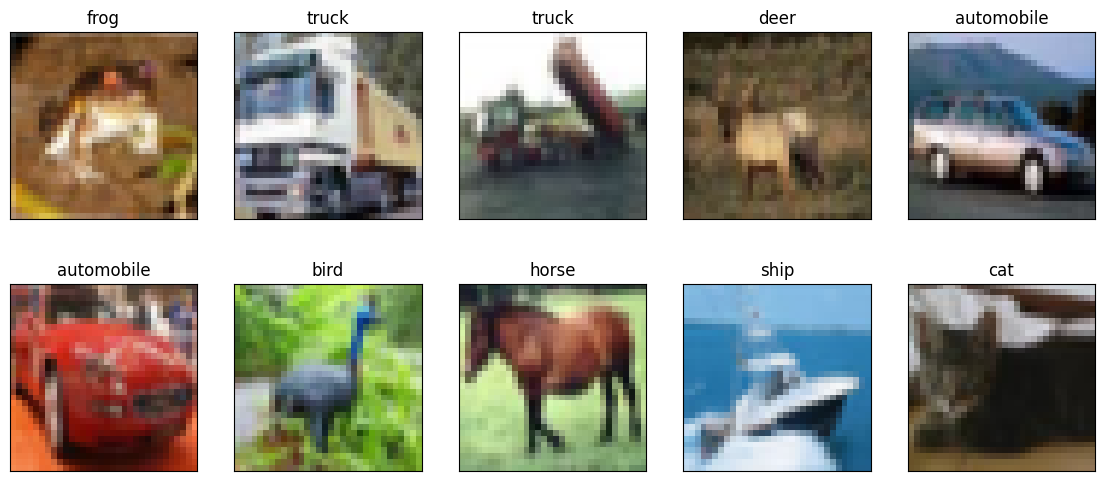

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_cifar_ds.data[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[int(train_cifar_ds.targets[i])])
plt.show()

**8. [2 marks]:** Try using the same model as we used for the MNIST (question 5) task to categorize these images.  You will need to change `input_shape=(28, 28)` to `input_shape=(3, 32, 32)` (note that PyTorch wants the color dimension before height and width), as these are now colour images of a different size.  Use 32 neurons in the hidden layer and train for 10 epochs.  Do this 10 times and plot the training accuracy and testing accuracy (including confidence intervals).  How well does the model perform?  Try increasing the number of hidden layer neurons (pick a number of neurons that seems reasonable given how much computer processing power you have).  How much does the system improve?

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

First we will train using 32 neurons for 10 epochs.

In [8]:
# MAKING THE MODEL
import torch.nn as nn
def make_softmax_model(num_hidden = 32, num_out=10):
    m = nn.Sequential(
      nn.Flatten(),                       # input is a 32x32x3 image for CIFAR
      nn.Linear(3*32*32, num_hidden, bias=True),    # 32 neurons in the middle "hidden" layer, have pytorch implement bias (default)
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden, num_out, bias=True),       # 10 outputs (one for each category)
      nn.Softmax(),                          # Add nonlinearity
    )
    return m


def cross_entropy_accuracy(y_pred, y_true):
    '''
    We need to change the accuracy function because the output is a vector encoding a distribution 
    over the categories, but the true label is just the class number.
    '''
    return (y_pred.argmax(dim=1) == y_true).float().sum()

In [ ]:
import scipy as sp
import numpy as np
import torch.optim as optim

history_array = []
for i in range(10):
    softmax_model = make_softmax_model(num_hidden=32)

    optimizer = optim.Adam(softmax_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
    criterion = nn.CrossEntropyLoss()

    history = train_model(
        softmax_model, 
        criterion, 
        cross_entropy_accuracy, 
        optimizer, 
        train_cifar_loader, 
        test_cifar_loader, 
        num_epochs=10, 
        batch_print=100,
    )

    history_array.append(history)

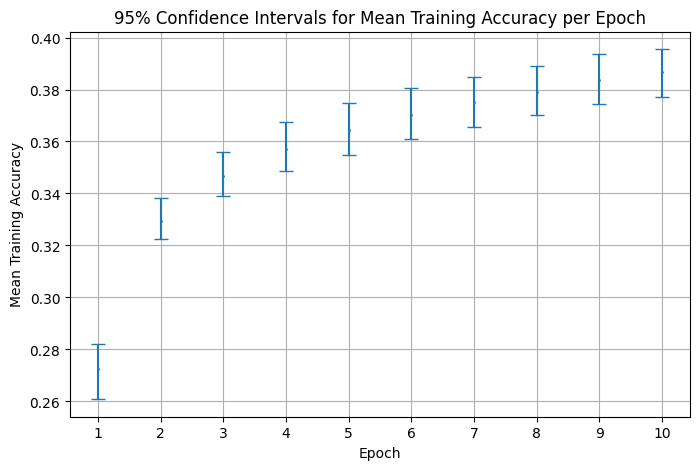

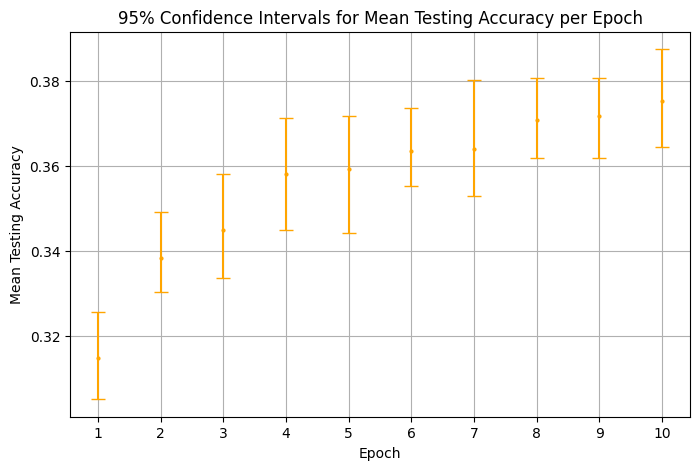

In [ ]:

# Extract epoch values
epoch_array = []
training_accuracies = np.array([history['accuracy'] for history in history_array])
testing_accuracies = np.array([history['val_accuracy'] for history in history_array])
for i in range(10):
    epoch_array.append((training_accuracies[:, i], testing_accuracies[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 11)
mean_accuracies_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_accuracies_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_accuracies_training - ci_lows_training, ci_highs_training - mean_accuracies_training]
plt.errorbar(epochs, mean_accuracies_training, yerr=error_bars_training, fmt='o', capsize=5, markersize=1)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Accuracy')
plt.title('95% Confidence Intervals for Mean Training Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 11)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_accuracies_testing - ci_lows_testing, ci_highs_testing - mean_accuracies_testing]
plt.errorbar(epochs, mean_accuracies_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange', markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Accuracy')
plt.title('95% Confidence Intervals for Mean Testing Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()



----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The model performs extremely poorly, barely achieving accuracy above 36%

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now let us add 256 neurons instead of 32. I am not expecting much improvement due to findings from question 6, but let us see:

In [ ]:
import scipy as sp
import numpy as np
import torch.optim as optim

history_array = []
for i in range(10):
    softmax_model = make_softmax_model(num_hidden=256)

    optimizer = optim.Adam(softmax_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
    criterion = nn.CrossEntropyLoss()

    history = train_model(
        softmax_model, 
        criterion, 
        cross_entropy_accuracy, 
        optimizer, 
        train_cifar_loader, 
        test_cifar_loader, 
        num_epochs=10, 
        batch_print=100,
    )

    history_array.append(history)

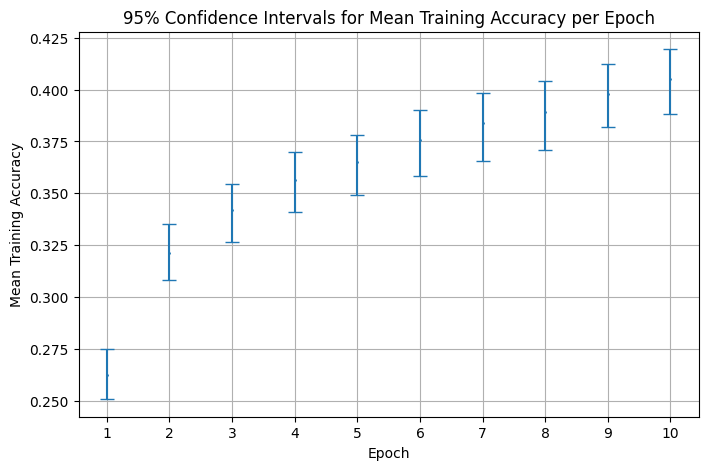

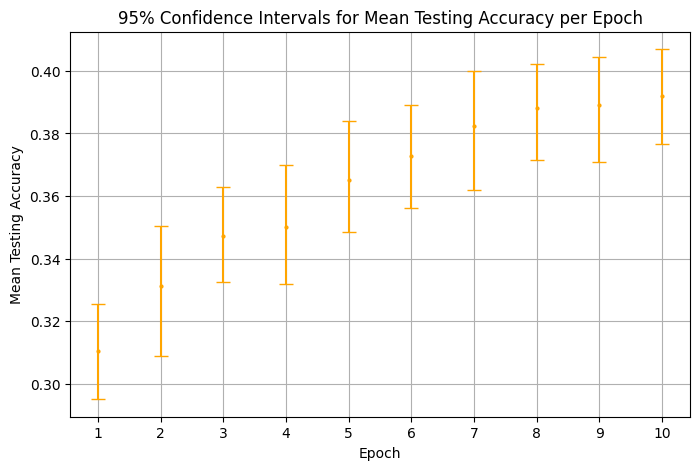

In [ ]:
# Extract epoch values
epoch_array = []
training_accuracies = np.array([history['accuracy'] for history in history_array])
testing_accuracies = np.array([history['val_accuracy'] for history in history_array])
for i in range(10):
    epoch_array.append((training_accuracies[:, i], testing_accuracies[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 11)
mean_accuracies_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_accuracies_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_accuracies_training - ci_lows_training, ci_highs_training - mean_accuracies_training]
plt.errorbar(epochs, mean_accuracies_training, yerr=error_bars_training, fmt='o', capsize=5, markersize=1)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Accuracy')
plt.title('95% Confidence Intervals for Mean Training Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 11)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_accuracies_testing - ci_lows_testing, ci_highs_testing - mean_accuracies_testing]
plt.errorbar(epochs, mean_accuracies_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange', markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Accuracy')
plt.title('95% Confidence Intervals for Mean Testing Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()



Adding more neurons did not help very much. We got very slightly better on our training data but not much changed at all for our testing data. Thus I can conclude that adding more neurons is not an effective solution if we wanted to improve performance. At least not for this model.

**9. [2 marks]:** To solve this task, let's try adding more layers.  In particular, let's add convolutional layers.  Here is a good network structure to start with:

In [37]:
def make_cnn_model():
    '''
    Note that we're hard-coding a lot of parameters here.
    Depending on the experiments you want to do, you should make them arguments to this function.
    '''
    m = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
        nn.ReLU(), # feature maps are now (32, 30, 30)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (32, 15, 15)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)), 
        nn.ReLU(), # Feature maps are now (64, 13, 13)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (64, 6, 6)
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
        nn.ReLU(), # Feature maps are now (64, 4, 4)
        nn.Flatten(),
        nn.Linear(in_features=64 * 4 * 4, out_features=64), # size of flattened data.
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10), 
        nn.Softmax(),
    )
    return m

cnn_model = make_cnn_model()

Now use the training function with the right optimizer and loss function.

In [ ]:
optimizer = optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()
history = train_model(
    cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_cifar_loader, 
    test_cifar_loader, 
    num_epochs=10, 
    batch_print=100,
)

Train this network for 10 epochs, and do this 10 times and plot the training and testing accuracy (including confidence intervals).  How well does the model perform?  

In [ ]:
import scipy as sp
import numpy as np
import torch.optim as optim

history_array = []
for i in range(10):
    cnn_model = make_cnn_model()

    optimizer = optim.Adam(cnn_model.parameters())
    criterion = nn.CrossEntropyLoss()
    history = train_model(
        cnn_model, 
        criterion, 
        cross_entropy_accuracy, 
        optimizer, 
        train_cifar_loader, 
        test_cifar_loader, 
        num_epochs=10, 
        batch_print=100,
    )
    history_array.append(history)

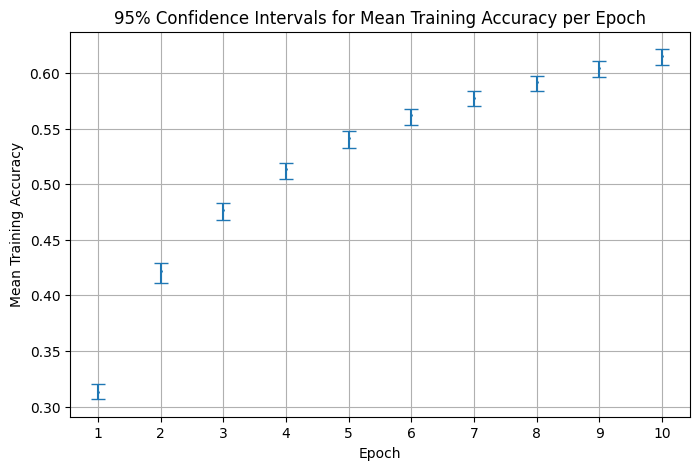

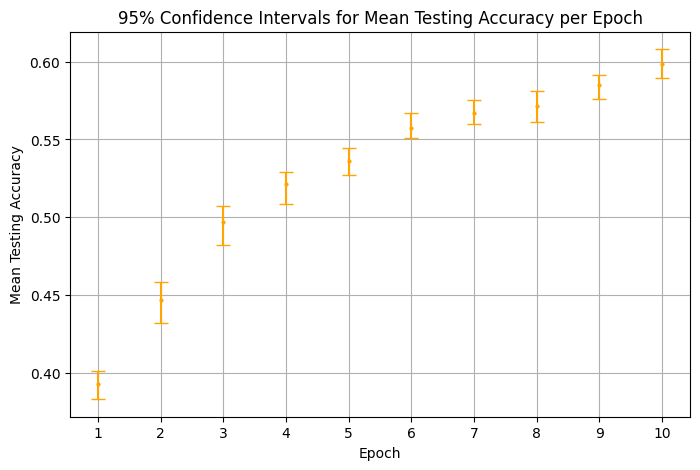

In [ ]:
# Extract epoch values
epoch_array = []
training_accuracies = np.array([history['accuracy'] for history in history_array])
testing_accuracies = np.array([history['val_accuracy'] for history in history_array])
for i in range(10):
    epoch_array.append((training_accuracies[:, i], testing_accuracies[:, i]))

# Initialize confidence interval arrays:
ci_highs_training = []
ci_lows_training = []
ci_highs_testing = []
ci_lows_testing = []

# Compute the confidence intervals using bootstrap for each epoch and print it
for epoch_values in epoch_array:
    (training_values, testing_values) = epoch_values
    ci_low_train, ci_high_train = sp.stats.bootstrap([training_values], np.mean).confidence_interval
    ci_low_test, ci_high_test = sp.stats.bootstrap([testing_values], np.mean).confidence_interval
    ci_lows_training.append(ci_low_train)
    ci_highs_training.append(ci_high_train)

    ci_lows_testing.append(ci_low_test)
    ci_highs_testing.append(ci_high_test)

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TRAINING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 11)
mean_accuracies_training = [np.mean(epoch_values[0]) for epoch_values in epoch_array]
mean_accuracies_testing = [np.mean(epoch_values[1]) for epoch_values in epoch_array]
ci_lows_training = np.array(ci_lows_training)
ci_highs_training = np.array(ci_highs_training)
error_bars_training = [mean_accuracies_training - ci_lows_training, ci_highs_training - mean_accuracies_training]
plt.errorbar(epochs, mean_accuracies_training, yerr=error_bars_training, fmt='o', capsize=5, markersize=1)
plt.xlabel('Epoch')
plt.ylabel('Mean Training Accuracy')
plt.title('95% Confidence Intervals for Mean Training Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()

# PLOT THE CONFIDENCE INTERVALS PER EPOCH FOR TESTING
plt.figure(figsize=(8,5))
epochs = np.arange(1, 11)
ci_lows_testing = np.array(ci_lows_testing)
ci_highs_testing = np.array(ci_highs_testing)
error_bars_testing = [mean_accuracies_testing - ci_lows_testing, ci_highs_testing - mean_accuracies_testing]
plt.errorbar(epochs, mean_accuracies_testing, yerr=error_bars_testing, fmt='o', capsize=5, color='orange', markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Mean Testing Accuracy')
plt.title('95% Confidence Intervals for Mean Testing Accuracy per Epoch')
plt.xticks(epochs)
plt.grid()
plt.show()

The model makes significant improvements to the accuracy, and is far better than previous approaches. It also seems to still be learning. Though, the overall accuracy is not good still.

**10. [2 marks]:** Improve the model as much as you can.  Remember that the goal is to increase the testing accuracy, not the training accuracy (after all, if we wanted perfect training accuracy, we could just write code that just memorizes all the training data and uses it as a lookup table).  Report what things you tried and how much they helped (or did not help).

It looked like the model was not done learning so maybe it will help if we increase to 20 epochs.

In [ ]:
import scipy as sp
import numpy as np
import torch.optim as optim

cnn_model = make_cnn_model()
optimizer = optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()
history = train_model(
    cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_cifar_loader, 
    test_cifar_loader, 
    num_epochs=20, 
    batch_print=100,
)


In [27]:
# Print the final accuracy
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy: {final_test_acc:.4f}')

Final Testing Accuracy: 0.6129


As expected, more epochs did not have much effect, though it was statistically significant. Another approach is needed.

I am going to try a far more complex CNN with more layers and batch normalization,

In [ ]:
def make_better_cnn_model():
    '''
    Improved CNN with batch normalization - more conservative approach
    '''
    m = nn.Sequential(
        # First conv block
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
        nn.BatchNorm2d(32),
        nn.ReLU(), # feature maps are now (32, 30, 30)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (32, 15, 15)
        
        # Second conv block  
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)), 
        nn.BatchNorm2d(64),
        nn.ReLU(), # Feature maps are now (64, 13, 13)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (64, 6, 6)
        
        # Third conv block
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
        nn.BatchNorm2d(128),
        nn.ReLU(), # Feature maps are now (128, 4, 4)
        
        # Fully connected layers
        nn.Flatten(),
        nn.Linear(in_features=128 * 4 * 4, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10), 
        nn.Softmax(),
    )
    return m

# Create and train the model
better_cnn_model = make_better_cnn_model()
optimizer = optim.Adam(better_cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = train_model(
    better_cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_cifar_loader, 
    test_cifar_loader, 
    num_epochs=15, 
    batch_print=100,
)

In [ ]:

# Print the final accuracy
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy with Deeper CNN: {final_test_acc:.4f}')

Final Testing Accuracy with Deeper CNN: 0.7133


This approach showed promise. I am going to increase the number of layers even further.

In [ ]:
def make_deeper_cnn_model():
    '''
    Even deeper CNN with more convolutional and fully connected layers
    '''
    m = nn.Sequential(
        # First conv block
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
        nn.BatchNorm2d(32),
        nn.ReLU(), # feature maps are now (32, 30, 30)
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
        nn.BatchNorm2d(32),
        nn.ReLU(), # feature maps are now (32, 28, 28)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (32, 14, 14)
        
        # Second conv block  
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)), 
        nn.BatchNorm2d(64),
        nn.ReLU(), # feature maps are now (64, 12, 12)
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)), 
        nn.BatchNorm2d(64),
        nn.ReLU(), # feature maps are now (64, 10, 10)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (64, 5, 5)
        
        # Third conv block
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
        nn.BatchNorm2d(128),
        nn.ReLU(), # feature maps are now (128, 3, 3)
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3)),
        nn.BatchNorm2d(128),
        nn.ReLU(), # feature maps are now (128, 1, 1)
        
        # Fully connected layers
        nn.Flatten(),
        nn.Linear(in_features=128 * 1 * 1, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10), 
        nn.Softmax(),
    )
    return m

# Create and train the model
deeper_cnn_model = make_deeper_cnn_model()
optimizer = optim.Adam(deeper_cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = train_model(
    deeper_cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_cifar_loader, 
    test_cifar_loader, 
    num_epochs=15, 
    batch_print=100,
)

In [ ]:
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy with Deeper CNN: {final_test_acc:.4f}')

Final Testing Accuracy with Deeper CNN: 0.5956


This got worse. Trying something different. I need to drastically change my approach since even 70% accuracy is not acceptable. I need to take a better approach to more effectively increasing the complexity of the CNN. I am going to implement dropout layers to ensure that better features are learned. I will also use batch normalization as before. Based on short investigation about CNNs, I have thrown together the following model: 

In [ ]:
import torch.nn as nn
import torch.optim as optim

def make_better_cnn_model():
    m = nn.Sequential(
        # First conv block
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),  # activation_1
        nn.BatchNorm2d(32),  # batch_normalization_1
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),  # activation_2
        nn.BatchNorm2d(32),  # batch_normalization_2
        nn.MaxPool2d(kernel_size=(2, 2)),  # max_pooling2d_1
        nn.Dropout(0.2),  # dropout_1
        
        # Second conv block
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),  # activation_3
        nn.BatchNorm2d(64),  # batch_normalization_3
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),  # activation_4
        nn.BatchNorm2d(64),  # batch_normalization_4
        nn.MaxPool2d(kernel_size=(2, 2)),  # max_pooling2d_2
        nn.Dropout(0.3),  # dropout_2
        
        # Third conv block
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),  # activation_5
        nn.BatchNorm2d(128),  # batch_normalization_5
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),  # activation_6
        nn.BatchNorm2d(128),  # batch_normalization_6
        nn.MaxPool2d(kernel_size=(2, 2)),  # max_pooling2d_3
        nn.Dropout(0.4),  # dropout_3
        
        # Fully connected layers
        nn.Flatten(),  # flatten_1
        nn.Linear(in_features=2048, out_features=10),  # dense_1 (128 * 4 * 4 = 2048)
        nn.Softmax(dim=1),  # softmax activation
    )
    return m

# Create and train the model
better_cnn_model = make_better_cnn_model()
optimizer = optim.Adam(better_cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = train_model(
    better_cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_cifar_loader, 
    test_cifar_loader, 
    num_epochs=15, 
    batch_print=100,
)

In [30]:
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy with Deeper CNN: {final_test_acc:.4f}')

Final Testing Accuracy with Deeper CNN: 0.7250


This accuracy is promising. Looking at it while running it looks like it is still learning even at 15 epochs. I am going to try and train this for 150 epochs just to see what happens. I will also be putting this on the gpu to speed things up.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set up GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def train_one_epoch_gpu(model, criterion, accuracy_fn, optimizer, training_loader, epoch_index, batch_print=1000):
    running_loss = 0.
    last_loss = 0.

    correct = 0
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        correct += accuracy_fn(outputs, labels)

        # Gather data and report
        running_loss += loss.item()
        if i % batch_print == batch_print-1:
            last_loss = running_loss / 1000
            print(f'  batch {i + 1} loss: {last_loss:.3e}')
            running_loss = 0.

    return last_loss, correct / len(training_loader.dataset)


def train_model_gpu(model, criterion, accuracy_fn, optimizer, training_loader, validation_loader=None, 
                num_epochs=5, batch_print=1000, eval_funcs=None, model_logging=False):
    from datetime import datetime
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    best_vloss = 1_000_000.
    
    training_loss = []
    validation_loss = []
    
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        print(f'EPOCH {epoch + 1}:')

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss, accuracy = train_one_epoch_gpu(model, criterion, accuracy_fn, optimizer, training_loader, epoch, batch_print=batch_print)

        training_loss.append(avg_loss)
        training_accuracy.append(accuracy)
        running_vloss = 0.0
        
        if validation_loader is None:
            # No validation data, skip evaluation
            continue
            
        # Set the model to evaluation mode
        model.eval()
        
        # Disable gradient computation and reduce memory consumption
        val_correct = 0
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)  # Move to GPU
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss

                val_correct += accuracy_fn(voutputs, vlabels)

        avg_vloss = running_vloss / (i + 1)
        val_acc = val_correct / len(validation_loader.dataset)
        
        validation_loss.append(avg_vloss)
        validation_accuracy.append(val_acc)
        print(f'LOSS train {avg_loss:.3e} valid {avg_vloss:.3e}, train acc {accuracy:.2f}, val acc {val_acc:.2f}')

        # Track best performance, and save the model's state
        if model_logging and avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)
        
    return {
        'loss':training_loss,
        'val_loss':validation_loss,
        'accuracy':training_accuracy,
        'val_accuracy':validation_accuracy,
    }

Using device: cuda


In [ ]:
def make_better_cnn_model():
    m = nn.Sequential(
        # First conv block
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.2),
        
        # Second conv block
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.3),
        
        # Third conv block
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.4),
        
        # Fully connected layers
        nn.Flatten(),
        nn.Linear(in_features=2048, out_features=10),
        nn.Softmax(dim=1),
    )
    return m

# Create and move model to GPU
better_cnn_model = make_better_cnn_model().to(device)
optimizer = optim.Adam(better_cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = train_model_gpu(
    better_cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_cifar_loader, 
    test_cifar_loader, 
    num_epochs=150, 
    batch_print=100,
)

In [33]:
final_test_acc = history['val_accuracy'][-1]
print(f'Final Testing Accuracy with Deeper CNN: {final_test_acc:.4f}')

Final Testing Accuracy with Deeper CNN: 0.8171


The CNN performed well compared to what I was expecting. It was learning far more than I initially anticipated. From previous approaches I learned a deeper CNN improves performance. I was able to leverage my gpu to investigate how extremely large epochs will affect performance after learning that most online resources that are training these models are running for hundreds of epochs, not just tens. I decided to apply this myself. 

I have learned that training for a far extended period of time and using a far deeper neural network is ideal and can train CIFAR-10 to high accuracy. I have gotten it to go from 60% accuracy all the way to 82%. The learning rate got extremely slow eventually, but was still progressing. Given the starting point and my limited knowledge on CNNs, I am satisfied with the result for now.

It looks like though slow, it was still learning. Perhaps more epochs would create better results. With the knowledge that I have now I feel like I was able to make substantial improvements to accuracy so I will stop iterating. The progress made seems that CNNs is a good model to keep improving.